In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 



def V_shell(r_outer, r_inner):
    #delta_r = r_outer - r_inner
    #if np.isclose(delta_r, 0, rtol=1e-12, atol=1e-20):
       # return 1e-10  
    #else:
        return (4/3) * np.pi * (r_outer**3 - r_inner**3)


def shells_mass(ri_arr, N, initial_density):
    m_shell = np.zeros(N)
    for j in range(N):
        if j == 0:
            m_shell[j] = initial_density * V_shell(ri_arr[j], 0)
        else:
            m_shell[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])
    return m_shell


def shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt):
    delta_M_arr = shells_mass(ri_arr, N, initial_density)   
    rho_shell = np.zeros(N)
    for j in range(N - 1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], 0)
            rho_shell[j] = (delta_M_arr[1] + delta_M_arr[0])/delta_V if delta_V > 0 else rho_sol[j, i-1]
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i])
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            rho_shell[j] = (delta_M_arr[j] + delta_M_arr[j+1])/delta_Vsum if delta_Vsum > 0 else rho_sol[j, i-1]

    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_shell[-1] = delta_M_arr[-1]/delta_V_last if delta_V_last > 0 else rho_sol[-1, i-1]
    return rho_shell




def qp_force_numerical(rho_var, r):
    #rho_var = np.clip(rho_var, 1e-10, np.inf)
    grad_rho = np.gradient(rho_var, r, edge_order=2)
    laplacian_rho = (1/(r**2)) * np.gradient((r**2) * grad_rho, r, edge_order=2)
    qp_term = (laplacian_rho/rho_var) - ((1/2) * (grad_rho**2) / (rho_var**2))
    return (1/4) * np.gradient(qp_term, r, edge_order=2)




def shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]
    for i in range(len(t_arr)):
        t = t_arr[i]
        dt_i = dt[i]
        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        #print(rho_arr)
        rho_sol[:, i] = rho_arr
        QP_arr = np.zeros(N)
        if QP==True:
            rho_var = rho_arr
            r_arr = r_sol[:, i]
            QP_arr = qp_force_numerical(rho_arr, r_arr) 
        else:
            QP_arr = np.zeros_like(r_sol[:, i])
        for j in range(N):
            if not mask_active[j]:
                continue
            dv_dt = 0
            if Hubble==True:
                dv_H_dt = -r_sol[j, i] / (4 * (t**2))
                dv_dt += dv_H_dt
            if gravity==True:
                dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
                dv_dt += dv_G_dt
            if QP==True:
                dv_QP_dt = QP_arr[j]
                dv_dt += dv_QP_dt
                #print(dv_dt)
            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i
            if not turnaround_detected[j]:
                rta_mask[j].append(r_sol[j, i])
                tta_mask[j].append(t_arr[i])
            if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i + 1]
                r_ta_arr[j] = r_next
                rta_mask[j].append(r_next)
                tta_mask[j].append(t_arr[i+1])
            #if turnaround_detected[j]:
               # mask_active[j] = False
                #cutoff_index[j] = i
               # continue
            if turnaround_detected[j]:
                after_steps = len(t_arr) - i
                rta_mask[j].extend([r_sol[j, i]] * after_steps)
                tta_mask[j].extend(t_arr[i:])
                r_sol[j, i + 1:] = r_sol[j, i]
                v_sol[j, i + 1:] = v_sol[j, i]
                mask_active[j] = False
                continue
            if i<len(t_arr)-1:
                r_sol[j, i + 1] = r_next
                v_sol[j, i + 1] = v_next
            else:
                r_sol[j, i] = r_sol[j, i-1]
                v_sol[j, i] = r_sol[j, i-1]
                
    return r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask

In [2]:
#Defining the initial conditions

t_i, t_f = 1e-15, 100
N = 7
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True

t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




[1.00000000e-08 4.64158883e-08 2.15443469e-07 1.00000000e-06
 4.64158883e-06 2.15443469e-05 1.00000000e-04]
Step 0, idx=0
[1.32442477e-06 6.15039924e-06 2.85476298e-05 1.32506366e-04
 6.15040067e-04 2.85476311e-03 1.32506366e-02]
Step 1, idx=2499
[1.63425172e-04 8.16383075e-04 3.78939820e-03 1.75889382e-02
 8.16406251e-02 3.78942214e-01 1.75889395e+00]
Step 2, idx=4999
[4.93599517e-04 9.01924223e-02 5.02446324e-01 2.33429235e+00
 1.08349311e+01 5.02913000e+01 2.33431537e+02]
Step 3, idx=7499
[4.93599517e-04 9.01924223e-02 7.43433758e+00 1.66844154e+02
 1.43484973e+03 6.66007065e+03 3.09133136e+04]
Step 4, idx=9999


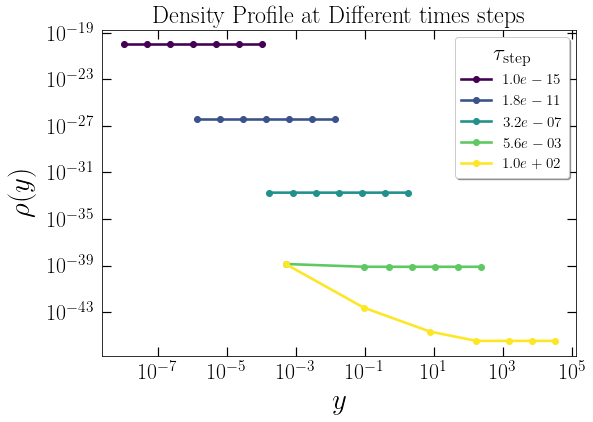

In [3]:


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 5, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)    
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend( prop = {'size':15.2},loc = 'upper right',shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy.pdf', bbox_inches = 'tight')
plt.show()

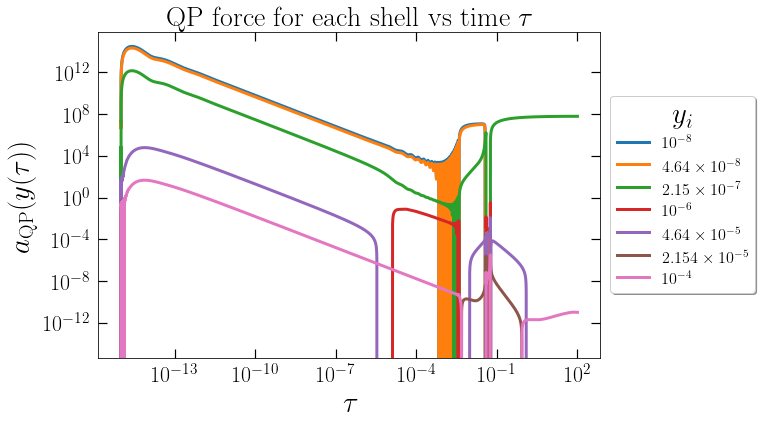

In [4]:
# For each shell, evolution of QP force with time

fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth= 3)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']



for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors[j])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)    
plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend([r'$10^{-8}$', r'$4.64\times10^{-8}$', r'$2.15\times10^{-7}$', r'$10^{-6}$', 
                                                                   r'$4.64\times10^{-5}$', r'$ 2.154\times10^{-5}$', r'$10^{-4}$'],prop = {'size':16.2},
              loc = (1.02, 0.2),shadow = True, title = '$y_{i}$' ,title_fontsize = 29,
           facecolor = 'white',fontsize = 25)

plt.title(r'QP force for each shell vs time $\tau$', fontsize= 28)
plt.savefig('QPforces_vs_tau.pdf', bbox_inches = 'tight')
plt.show()


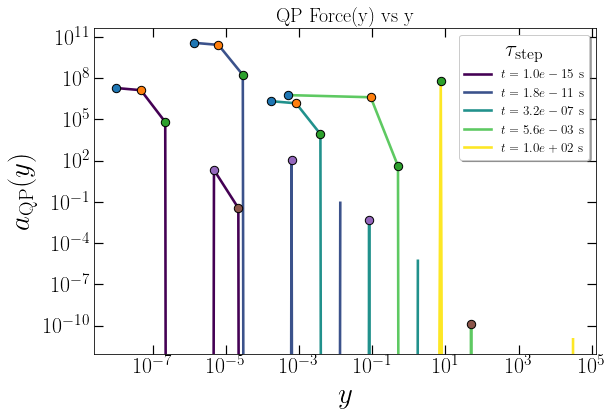

In [5]:
# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)

fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

time_indices = np.linspace(0, t_step - 1, 5, dtype=int)
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)

    ax.loglog(r_arr, qp_val, color=colors[k], label=f'$t = {t_arr[idx]:.1e}$ s')

    for shell_index in range(N-1):
        shell_color = colors_shell[shell_index % len(colors_shell)]
        ax.scatter(r_arr[shell_index], qp_val[shell_index],
                   edgecolor='black', s=70, zorder=5, color= shell_color)

ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y)$', fontsize=29, labelpad=6)
ax.set_title(f'QP Force(y) vs y ', fontsize=20)
ax.legend(prop={'size': 13.2}, loc='upper right', shadow=True,
          title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('qp_vs_r_N7.pdf', bbox_inches='tight')
plt.show()
